<a href="https://colab.research.google.com/github/samezqui/fullofstars/blob/skymap/df_astroplan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!pip install astroplan
!pip install pytz
!pip install matplotlib
!pip install astropy 

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import numpy as np
import warnings

__all__ = ['plot_sky']

import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import EarthLocation, SkyCoord, ICRS
from pytz import timezone
from astropy.time import Time

from astroplan import Observer
from astroplan import FixedTarget


In [0]:
def plot_sky(target, observer, time, ax=None, style_kwargs=None,
             north_to_east_ccw=True, grid=True, az_label_offset=0.0*u.deg,
             warn_below_horizon=False, style_sheet=None):
    """
    Plots target positions in the sky with respect to the observer's location.

    If a `~matplotlib.axes.Axes` object already exists, plots an additional
    target position on top.
    Otherwise, creates a new `~matplotlib.axes.Axes` object with a sky plot.

    Can pass in a scalar `~astropy.time.Time` object (e.g. ``Time('2000-1-1')``)
    or an array of length one (e.g. ``Time(['2000-1-1'])``) to get plot at one
    instance in time.
    If pass in an `~astropy.time.Time` object with multiple instances of time
    (e.g. ``Time(['2000-1-1 20:00:00', '2000-1-1 20:30:00'])``), target's
    position will be shown at each of these times.

    For examples with plots, visit the documentation of :ref:`plots_sky_charts`.

    Parameters
    ----------
    target : `~astroplan.FixedTarget`
        The celestial body of interest.

    observer : `~astroplan.Observer`
        The person, telescope, observatory, etc. doing the observing.

    time : `~astropy.time.Time`
        If pass in an `~astropy.time.Time` object with just one instance in
        time, whether it be a scalar or an array (e.g. ``Time('2000-1-1')``,
        ``Time(['2000-1-1'])``, ``[Time('2000-1-1')]``),
        `~astroplan.plots.plot_sky` will return plot at one instance in
        time.  If pass in an `~astropy.time.Time` object with multiple
        instances in time (e.g. ``Time(['2000-1-1', '2000-1-2'])``) will
        show positions plotted at the exact times specified.

    ax : `~matplotlib.axes.Axes` or None, optional.
        The `~matplotlib.axes.Axes` object to be drawn on.
        If None, uses the current `~matplotlib.axes.Axes`.

    style_kwargs : dict or None, optional.
        A dictionary of keywords passed into `~matplotlib.pyplot.scatter`
        to set plotting styles.

    north_to_east_ccw : bool, optional.
        True by default, meaning that azimuth is shown increasing
        counter-clockwise (CCW), or with North at top, East at left, etc.
        To show azimuth increasing clockwise (CW), set to False.

    grid : bool, optional.
        True by default, meaning that grid is drawn.

    az_label_offset : ``~astropy.units.degree``, optional.
        DANGER: It is not recommended that you change the default behavior,
        as to do so makes it seem as if N/E/S/W are being decoupled from the
        definition of azimuth (North from az = 0 deg., East from az = 90 deg.,
        etc.).
        An offset for azimuth labels from the North label.  A positive
        offset will increase in the same direction as azimuth
        (see ``north_to_east_ccw`` option).

    warn_below_horizon : bool, optional
        If `False`, don't show warnings when attempting to plot targets below
        the horzion.

    style_sheet : dict or `None` (optional)
        matplotlib style sheet to use. To see available style sheets in
        astroplan, print *astroplan.plots.available_style_sheets*. Defaults
        to the light theme.

    Returns
    -------
    An `~matplotlib.axes.Axes` object (ax) with a map of the sky.

    Notes
    -----
    Using `~astropy.time.Time` objects:
        See `Astropy`_ documentation for more details.

    Coordinate defaults:

        Altazimuth (local horizon) coordinate system.  North is always at top
        of plot, South is always at the bottom, E/W can be right or left
        depending on the ``north_to_east_cw`` option.

        Altitude: 90 degrees (zenith) is at plot origin (center) and 0 degrees
        (horizon) is at plot edge.  This cannot be changed by user.

        Azimuth: 0 degrees is at North (top of plot), 90 degrees at East, etc.
        DANGER: Azimuth labels can be changed by user via the
        ``az_label_offset`` option, but it is not recommended, as to do so
        makes it seem as if N/E/S/W are being decoupled from the definition
        of azimuth (North from az = 0 deg., East from az = 90 deg., etc.).

    """
    # Import matplotlib, set style sheet
    if style_sheet is not None:
        _set_mpl_style_sheet(style_sheet)

    import matplotlib.pyplot as plt

    # Set up axes & plot styles if needed.
    if ax is None:
        ax = plt.gca(projection='polar')
    if style_kwargs is None:
        style_kwargs = {}
    style_kwargs = dict(style_kwargs)
    style_kwargs.setdefault('marker', 'o')

    # Turn scalar Time objects into arrays.
    time = Time(time)
    if time.isscalar:
        time = Time([time])

    # Grab altitude and azimuth from Astroplan objects.
    # Note that values must be made dimensionless before plotting.
    # Modifying altitude is easier than inverting r-axis.
    altitude = (91 * u.deg - observer.altaz(time, target).alt) * (1/u.deg)
    # Azimuth MUST be given to plot() in radians.
    azimuth = observer.altaz(time, target).az * (1/u.deg) * (np.pi/180.0)

    # Some checks & info for labels.
    if not hasattr(target, 'name'):
        target_name = ''
    else:
        target_name = target.name
    style_kwargs.setdefault('label', target_name)

    # We only want to plot positions above the horizon.
    az_plot = None
    for alt in range(0, len(altitude)):
        if altitude[alt] > 91.0:
            if warn_below_horizon:
                msg = 'Target "{0}" is below the horizon at time: {1}'
                msg = msg.format(target_name if target_name else 'Unknown Name',
                                 time[alt])
                warnings.warn(msg, PlotBelowHorizonWarning)
        else:
            if az_plot is None:
                az_plot = np.array([azimuth[alt]])
            else:
                az_plot = np.append(az_plot, azimuth[alt])
    alt_plot = altitude[altitude <= 91.0]
    if az_plot is None:
        az_plot = []

    # More axes set-up.
    # Position of azimuth = 0 (data, not label).
    ax.set_theta_zero_location('N')

    # Direction of azimuth increase. Clockwise is -1
    if north_to_east_ccw is False:
        ax.set_theta_direction(-1)

    # Plot target coordinates.
    ax.scatter(az_plot, alt_plot, **style_kwargs)

    # Set radial limits.
    ax.set_rlim(1, 91)

    # Grid, ticks & labels.
    # May need to set ticks and labels AFTER plotting points.
    if grid is True:
        ax.grid(True, which='major')
    if grid is False:
        ax.grid(False)
    degree_sign = u'\N{DEGREE SIGN}'

    # For positively-increasing range (e.g., range(1, 90, 15)),
    # labels go from middle to outside.
    r_labels = [
        '90' + degree_sign,
        '',
        '60' + degree_sign,
        '',
        '30' + degree_sign,
        '',
        '0' + degree_sign + ' Alt.',
    ]

    theta_labels = []
    for chunk in range(0, 7):
        label_angle = (az_label_offset*(1/u.deg)) + (chunk*45.0)
        while label_angle >= 360.0:
            label_angle -= 360.0
        if chunk == 0:
            theta_labels.append('N ' + '\n' + str(label_angle) + degree_sign
                                + ' Az')
        elif chunk == 2:
            theta_labels.append('E' + '\n' + str(label_angle) + degree_sign)
        elif chunk == 4:
            theta_labels.append('S' + '\n' + str(label_angle) + degree_sign)
        elif chunk == 6:
            theta_labels.append('W' + '\n' + str(label_angle) + degree_sign)
        else:
            theta_labels.append(str(label_angle) + degree_sign)

    # Set ticks and labels.
    ax.set_rgrids(range(1, 106, 15), r_labels, angle=-45)
    ax.set_thetagrids(range(0, 360, 45), theta_labels)

   

    # Redraw the figure for interactive sessions.
    ax.figure.canvas.draw()

    return ax

##Set up Observer

In [0]:
observer = Observer(longitude=-86.237930*u.deg, latitude=41.700191*u.deg,
                  elevation=224*u.m, name="Notre Dame", timezone="US/Eastern")
# could still add, pressure, relative humidity, temperature 
# pressure = ### * u.bar
# relative_humidity = ##
# temperature = ### * u.deg_C


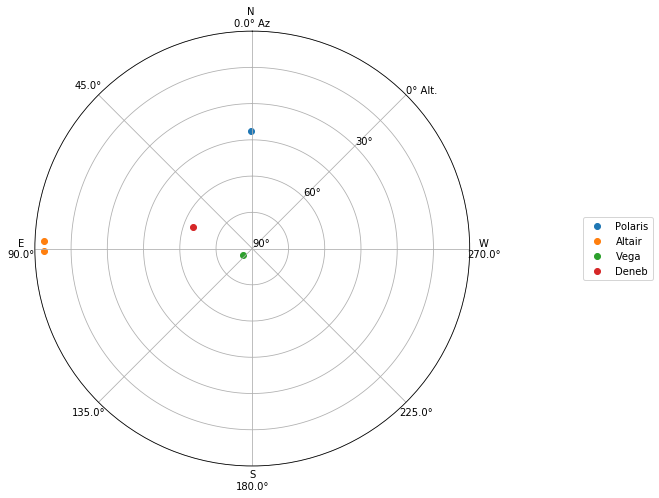

In [22]:
# Set up Observer, Target and observation time objects.


coordinates = SkyCoord('02h31m49.09s', '+89d15m50.8s', frame='icrs')
polaris = FixedTarget(name='Polaris', coord=coordinates)


coordinates = SkyCoord([ICRS(ra=1*u.deg, dec=2*u.deg), ICRS(ra=3*u.deg, dec=4*u.deg)])
altair = FixedTarget(name='Altair', coord=coordinates)
# plots two points!!
# uses ra and deg for coordinates
# can use skyfield data 

coordinates = SkyCoord('18h36m56.5s', '+38d47m06.6s', frame='icrs')
vega = FixedTarget(name='Vega', coord=coordinates)


coordinates = SkyCoord('20h41m25.9s', '+45d16m49.3s', frame='icrs')
deneb = FixedTarget(name='Deneb', coord=coordinates)


# Note that this is not a scalar.
observe_time = Time(['2019-5-7T09:04:05.678'])

plot_sky(polaris, observer, observe_time)
plot_sky(altair, observer, observe_time)
plot_sky(vega, observer, observe_time)
plot_sky(deneb, observer, observe_time)

# Note that you don't need this code block to produce the plot.
# It reduces the plot size for the documentation.
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width *2, box.height * 2])

plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5))

plt.show()

##Constellations using SkyCoord

function: get_constellation

Only determines of the point being observed belongs to an accepted IAU constellation and which one

## Finding data on Constellations

Next step will be finding a data frame that condenses the stars and their locations based on being in the same constellation

I need to find the hipparcos dataframe and how to access it, so I can manipulate the data 
  Found it, and does not provide constellation information based on what I already have
  
May resolve to making my own CSV with information based on the misc_astral data in GitHub 